Source: 

https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-for-text-classification-tasks

#Kaggle

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# upload JSON file with account info from kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aleksmitk","key":"bba949f84eb8bac61aff3e5e51ea87e0"}'}

In [3]:
# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
# Choose the kaggle.json file that you downloaded
! cp kaggle.json ~/.kaggle/
# Download dataset from kaggle
! kaggle datasets download neisse/scrapped-lyrics-from-6-genres
! unzip scrapped-lyrics-from-6-genres
! rm -r scrapped-lyrics-from-6-genres.zip

 99% 128M/129M [00:07<00:00, 21.4MB/s]
100% 129M/129M [00:07<00:00, 17.4MB/s]
Archive:  scrapped-lyrics-from-6-genres.zip
  inflating: artists-data.csv        
  inflating: lyrics-data.csv         


# Preprocessing

In [4]:
import pandas as pd
lyrics_data = pd.read_csv("/content/lyrics-data.csv")
artists_data = pd.read_csv("/content/artists-data.csv")

lyrics_data = lyrics_data.rename({"ALink":"Link"}, axis="columns")
data = lyrics_data.merge(artists_data, on='Link', how='left')
data = data.drop(["Link", "SName", "SLink", "Songs", "Popularity"], axis=1)
data = data.loc[data["language"] == "en"]
data[['Genre1', 'Genre2', 'Genre3', 'Genre4']] = data['Genres'].str.split(';', -1, expand=True)
data = data[data['Genre1'].notna()]
data = data.drop("Genres", axis=1)
data = data.reset_index().drop("index", axis=1)
genre_list = ["Rock","Pop","Indie","Rap","Country","R&B","Heavy Metal","Soul Music"]
data = data[data["Genre1"].isin(genre_list)]

decode_labels = {}
i = 0
for label in data["Genre1"].unique():
  decode_labels[i] = label
  i += 1
encode_labels = {v: k for k, v in decode_labels.items()}

import re 

def clean_lyrics(lyrics):
    lyrics = re.sub(r"[^A-Za-z0-9']+", " ", lyrics, flags=re.MULTILINE)
    lyrics = re.sub(r"(?<=[a-zA-Z0-9]) (?=['])|(?<=[']) (?=[a-zA-Z0-9])", "", lyrics, flags=re.MULTILINE)
    lyrics = re.sub('\s+',' ',lyrics)
    return lyrics.lower().lstrip()

for index, row in data.iterrows(): #encode labels in dataset 
  label = encode_labels[row["Genre1"]]
  data.loc[index,'Label'] = label

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.05)


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [5]:
from torch.utils.data import Dataset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)


class AudioDataset(Dataset):
  def __init__(self, dataset: pd.DataFrame):
      self.lyrics = dataset['Lyric'].tolist()
      self.labels = dataset["Label"].tolist()

  def __len__(self):
      return len(self.lyrics)

  def __getitem__(self, index: int):
      feat = clean_lyrics(self.lyrics[index])
      label = int(self.labels[index])
      
      return (label, feat)
  
  def collate_fn(batch):
      label_list = [torch.tensor(label_pipeline(b[0])) for b in batch]
      feat_list = [torch.tensor(text_pipeline(b[1])) for b in batch]

      feats = torch.nn.utils.rnn.pad_sequence(feat_list, batch_first = True)
      labels = torch.tensor(label_list, dtype=torch.int64)

      """
      print(f"Features shape: {feats.shape}")
      print(f"Labels shape: {labels.shape}")
      print(f"Length of tensor: {len(feats[1])}")
      translation = []
      [translation.append(" " + str(vocab.lookup_token(word.item()))) for word in feats[1]]
      translation = ''.join(translation)
      print(f"Translated tensor: {translation}")
      print(f"Corresponding label: {decode_labels[labels[1].item()]}")
      """

      return feats.to(device), labels.to(device)

    
train_iter = AudioDataset(dataset=train_data)
test_iter = AudioDataset(dataset=test_data)

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<pad>","<unk>"], min_freq = 500)
vocab.set_default_index(vocab["<unk>"])

dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=AudioDataset.collate_fn)
test_loader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=AudioDataset.collate_fn)

In [6]:
import numpy as np
torch.set_printoptions(profile="full")#"default"
print("Model overview:")
print(" ")

for X, Y in dataloader:
  
  break

Model overview:
 


In [7]:
data[data["Lyric"].str.contains("Ain't a day goes by")]

,Lyric,language,Artist,Genre1,Genre2,Genre3,Genre4,Label
47962,"Ain't a day goes by, I don't burn a little bit...",en,Neil Young,Rock,Folk,None,None,4.0


# Model und Training Tests

In [8]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 75
n_layers=1
num_class = len(set([label for (label, text) in train_iter]))

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_class)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(embeddings, (hidden.to(device), carry.to(device)))
        return self.linear(output[:,-1])

In [9]:
lstm_classifier = LSTMClassifier().to(device)

lstm_classifier

LSTMClassifier(
  (embedding_layer): Embedding(2670, 50)
  (lstm): LSTM(50, 75, batch_first=True)
  (linear): Linear(in_features=75, out_features=8, bias=True)
)

In [10]:
for layer in lstm_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(2670, 50)
Parameters : 
torch.Size([2670, 50])

Layer : LSTM(50, 75, batch_first=True)
Parameters : 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer : Linear(in_features=75, out_features=8, bias=True)
Parameters : 
torch.Size([8, 75])
torch.Size([8])



In [11]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X) ## Make Predictions

            loss = loss_fn(Y_preds, Y) ## Calculate Loss
            losses.append(loss.item())

            optimizer.zero_grad() ## Clear previously calculated gradients
            loss.backward() ## Calculates Gradients
            optimizer.step() ## Update network weights.

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [12]:
from torch.optim import Adam

epochs = 30
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier().to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

TrainModel(lstm_classifier, loss_fn, optimizer, dataloader, test_loader, epochs)

100%|██████████| 10952/10952 [01:25<00:00, 128.12it/s]


Train Loss : 1.770
Valid Loss : 1.644
Valid Acc  : 0.384


100%|██████████| 10952/10952 [01:23<00:00, 130.43it/s]


Train Loss : 1.505
Valid Loss : 1.387
Valid Acc  : 0.468


100%|██████████| 10952/10952 [01:24<00:00, 129.08it/s]


Train Loss : 1.362
Valid Loss : 1.293
Valid Acc  : 0.505


100%|██████████| 10952/10952 [01:24<00:00, 129.57it/s]


Train Loss : 1.293
Valid Loss : 1.235
Valid Acc  : 0.531


100%|██████████| 10952/10952 [01:24<00:00, 129.31it/s]


Train Loss : 1.243
Valid Loss : 1.190
Valid Acc  : 0.551


100%|██████████| 10952/10952 [01:23<00:00, 130.75it/s]


Train Loss : 1.201
Valid Loss : 1.154
Valid Acc  : 0.568


100%|██████████| 10952/10952 [01:24<00:00, 129.75it/s]


Train Loss : 1.164
Valid Loss : 1.119
Valid Acc  : 0.584


100%|██████████| 10952/10952 [01:23<00:00, 130.97it/s]


Train Loss : 1.128
Valid Loss : 1.094
Valid Acc  : 0.594


100%|██████████| 10952/10952 [01:23<00:00, 130.79it/s]


Train Loss : 1.096
Valid Loss : 1.073
Valid Acc  : 0.602


100%|██████████| 10952/10952 [01:23<00:00, 131.11it/s]


Train Loss : 1.065
Valid Loss : 1.042
Valid Acc  : 0.616


100%|██████████| 10952/10952 [01:23<00:00, 130.69it/s]


Train Loss : 1.037
Valid Loss : 1.023
Valid Acc  : 0.623


100%|██████████| 10952/10952 [01:25<00:00, 127.69it/s]


Train Loss : 1.008
Valid Loss : 0.999
Valid Acc  : 0.632


100%|██████████| 10952/10952 [01:27<00:00, 125.67it/s]


Train Loss : 0.984
Valid Loss : 0.987
Valid Acc  : 0.636


100%|██████████| 10952/10952 [01:27<00:00, 125.40it/s]


Train Loss : 0.961
Valid Loss : 0.968
Valid Acc  : 0.644


100%|██████████| 10952/10952 [01:25<00:00, 127.37it/s]


Train Loss : 0.942
Valid Loss : 0.957
Valid Acc  : 0.648


100%|██████████| 10952/10952 [01:26<00:00, 126.93it/s]


Train Loss : 0.920
Valid Loss : 0.942
Valid Acc  : 0.655


100%|██████████| 10952/10952 [01:25<00:00, 127.70it/s]


Train Loss : 0.903
Valid Loss : 0.930
Valid Acc  : 0.660


100%|██████████| 10952/10952 [01:26<00:00, 127.29it/s]


Train Loss : 0.890
Valid Loss : 0.923
Valid Acc  : 0.663


100%|██████████| 10952/10952 [01:25<00:00, 127.94it/s]


Train Loss : 0.874
Valid Loss : 0.910
Valid Acc  : 0.669


100%|██████████| 10952/10952 [01:25<00:00, 128.01it/s]


Train Loss : 0.863
Valid Loss : 0.916
Valid Acc  : 0.669


100%|██████████| 10952/10952 [01:25<00:00, 127.78it/s]


Train Loss : 0.854
Valid Loss : 0.904
Valid Acc  : 0.670


100%|██████████| 10952/10952 [01:25<00:00, 128.08it/s]


Train Loss : 0.842
Valid Loss : 0.882
Valid Acc  : 0.680


100%|██████████| 10952/10952 [01:26<00:00, 127.23it/s]


Train Loss : 0.833
Valid Loss : 0.873
Valid Acc  : 0.684


100%|██████████| 10952/10952 [01:25<00:00, 127.98it/s]


Train Loss : 0.822
Valid Loss : 0.859
Valid Acc  : 0.690


100%|██████████| 10952/10952 [01:26<00:00, 126.67it/s]


Train Loss : 0.810
Valid Loss : 0.841
Valid Acc  : 0.696


100%|██████████| 10952/10952 [01:25<00:00, 128.26it/s]


Train Loss : 0.805
Valid Loss : 0.849
Valid Acc  : 0.695


100%|██████████| 10952/10952 [01:25<00:00, 127.69it/s]


Train Loss : 0.797
Valid Loss : 0.845
Valid Acc  : 0.696


100%|██████████| 10952/10952 [01:25<00:00, 127.83it/s]


Train Loss : 0.790
Valid Loss : 0.851
Valid Acc  : 0.693


100%|██████████| 10952/10952 [01:25<00:00, 128.03it/s]


Train Loss : 0.787
Valid Loss : 0.825
Valid Acc  : 0.703


100%|██████████| 10952/10952 [01:26<00:00, 126.97it/s]


Train Loss : 0.786
Valid Loss : 0.823
Valid Acc  : 0.701


In [13]:
PATH = "lstm_model.pth"
torch.save(lstm_classifier.state_dict(), PATH)

In [14]:
torch.cuda.empty_cache()
gc.collect()

0

In [15]:
def MakePredictions(model, loader):
      Y_shuffled, Y_preds = [], []
      with torch.no_grad():
        for X, Y in loader:
            preds = model(X)
            Y_preds.append(preds)
            Y_shuffled.append(Y)
        gc.collect()
        Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

      return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader)


In [16]:
target_classes = []
for index, genre in decode_labels.items():
  target_classes.append(genre)

print(target_classes)

['Pop', 'R&B', 'Rap', 'Soul Music', 'Rock', 'Indie', 'Heavy Metal', 'Country']


In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.7030509867482394

Classification Report : 
              precision    recall  f1-score   support

         Pop       0.65      0.62      0.64     13109
         R&B       0.70      0.48      0.57      5025
         Rap       0.87      0.89      0.88      9095
  Soul Music       0.51      0.44      0.48      4286
        Rock       0.61      0.80      0.69     23918
       Indie       0.70      0.60      0.64     12346
 Heavy Metal       0.89      0.77      0.83     12790
     Country       0.83      0.67      0.74      7042

    accuracy                           0.70     87611
   macro avg       0.72      0.66      0.68     87611
weighted avg       0.71      0.70      0.70     87611


Confusion Matrix : 
[[ 8185   390   443   369  2643   848    63   168]
 [ 1008  2412   503   475   458    97    15    57]
 [  368   323  8125    51   150    62    14     2]
 [  546   222    85  1902  1217    80    17   217]
 [ 1089    47   151   534 19033  1738   940   386]
 [  912    2

In [18]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


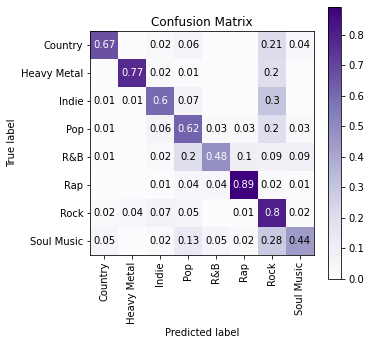

In [19]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [20]:
plt.savefig("confusion_matrix")

<Figure size 432x288 with 0 Axes>